In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wednesday October 10 10:11:42 2023
Example Code for training an MRI Image Reconstruction Network from Inter4k Dataset

Methods details in : 
XXX

@author: Dr. Olivier Jaubert
"""
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
import numpy as np
import tensorflow as tf
try:  tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
except: print('running on CPU')
import tensorflow_mri as tfmri
import random
import matplotlib.pyplot as plt
import datetime
import json

# # Local imports (works if you are in project folder)
import utils.create_tensorflow_dataset as dataset_utils
import utils.model_utils as model_utils
import utils.display_function as display_func

#Set seed for all packages
seed_value=1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
;

2023-11-03 17:16:21.160367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 17:16:21.482211: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 17:16:22.144145: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/oj20/miniconda3/envs/tf022/lib/:/lib:/home/oj20/miniconda3/lib/:/lib:/home/oj20/miniconda3/lib/:/lib:
2023-11-03 17:16:22.144200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

''

In [2]:
result_folder='TrainingFolder'
model_type='FastDVDNet'
exp_name='Default_'+model_type
DEBUG=False
data_folder = './DatasetFolder/Inter4K/60fps/UHD/'
cache_dir = './DatasetFolder/DEBUG/' if DEBUG else './DatasetFolder/temp'
#Total number of samples from dataset used 
n= 12 if DEBUG else 692
reset=2
filenames_datasets=dataset_utils.split_training_test_set(data_folder,n=n,split=[0.75,0.10,0.15],verbose=1)
preproc_datasets=dataset_utils.run_preproc_v2(filenames_datasets,cache_dir,reset=reset)
if model_type=='VarNet':
    dataset_withtransforms=dataset_utils.generate_dataset_VarNet(filenames_datasets,cache_dir,reset=reset,DEBUG=DEBUG)
elif model_type=='3DUNet':
    dataset_withtransforms=dataset_utils.generate_dataset_radial3DUNet(filenames_datasets,cache_dir,reset=reset,DEBUG=DEBUG)
elif model_type=='FastDVDNet':
    dataset_withtransforms=dataset_utils.generate_dataset_FastDVDNet_v2(preproc_datasets,cache_dir,reset=reset,DEBUG=DEBUG)

100%|██████████| 1000/1000 [00:00<00:00, 3279362.00it/s]


Total/Train/Val/Test: 692 / 519 / 69 / 104 leftovers: 0


2023-11-03 17:16:33.716498: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7464960000 exceeds 10% of free system memory.


Saving Dataset Train


2023-11-03 17:16:44.644277: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7464960000 exceeds 10% of free system memory.
2023-11-03 17:16:51.221829: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7464960000 exceeds 10% of free system memory.
2023-11-03 17:16:57.703149: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7440076800 exceeds 10% of free system memory.
2023-11-03 17:17:04.104929: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7440076800 exceeds 10% of free system memory.


In [ ]:
inputs_temp=next(iter(dataset_withtransforms[0].take(1)))
print(inputs_temp[0].shape)
#To modify model architecture:
# config_model={'filters': [16,32,46,64]}
config_model=dict()
#To modify learning params :
# learning_params={'learning_rate': 0.005}
learning_params=dict()

model=model_utils.load_models(inputs_temp,model_type,DEBUG=DEBUG)
learning_params=model_utils.load_learning_params(model_type,DEBUG=DEBUG,learning_params=learning_params)
print(learning_params)
model.compile(optimizer=learning_params['optimizer'],
                    loss=learning_params['loss'],
                    metrics=learning_params['metrics'],
                    run_eagerly=False)
model.summary()

2023-11-03 11:22:59.969835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-11-03 11:23:06.144768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4
2023-11-03 11:23:12.117308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-11-03 11:23:18.599208: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-03 11:23:18.601449: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected

(1, 240, 240, 5)
(1, 240, 240, 5)
{'learning_rate': 0.0001, 'loss': <tensorflow_mri.python.losses.iqa_losses.SSIMLoss object at 0x7fb2a86d2b20>, 'epochs': 200, 'metrics': [<tensorflow_mri.python.metrics.iqa_metrics.PSNR object at 0x7fb2082648b0>, <tensorflow_mri.python.metrics.iqa_metrics.SSIM object at 0x7fb208218550>], 'optimizer': <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fb2081ff040>}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 5)]     0         
                                                                 
 fast_dvd_net_1 (FastDVDNet)  (None, 240, 240, 1)      1589506   
                                                                 
Total params: 1,589,506
Trainable params: 1,589,506
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Defining Paths
exp_name += '_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
exp_dir = os.path.join(result_folder, exp_name)

callbacks=[]
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
callbacks.append(tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_weights_only=False,
        save_best_only=True))
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=os.path.join(exp_dir,'logs')))

In [ ]:
#Train Model
history=model.fit(dataset_withtransforms[0],
          epochs=learning_params['epochs'],
          verbose=1,
          callbacks=callbacks,
          validation_data=dataset_withtransforms[1]
          )

Epoch 1/200


2023-11-03 11:23:37.654670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 4
2023-11-03 11:23:43.746640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 4


  1/519 [..............................] - ETA: 4:17:56 - loss: 0.9284 - psnr: 14.1137 - ssim: 0.0716

2023-11-03 11:23:49.694097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


152/519 [=======>......................] - ETA: 37:21 - loss: 0.3711 - psnr: 23.4040 - ssim: 0.6289

: 

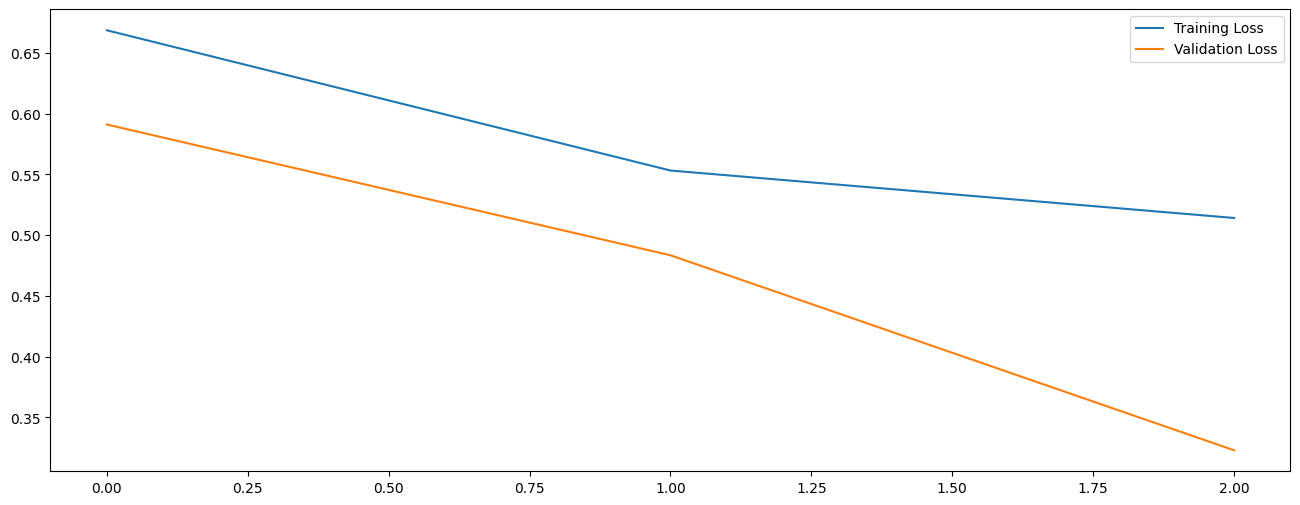

In [ ]:
fig = plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
leg = plt.legend()

In [ ]:
#Evaluate On Test Set
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
model.load_weights(checkpoint_filepath)
result = model.evaluate(dataset_withtransforms[2])
if model_type=='VarNet':
    results_dict={model.metrics_names[0]: result} #when only 1 metric
else:
    results_dict=dict(zip(model.metrics_names, result))
filename = os.path.join(exp_dir,'results.json')
with open(filename, 'w') as f:
    f.write(json.dumps(results_dict))

2023-11-03 11:20:51.131836: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open TrainingFolder/Default_FastDVDNet_20231103_111924/ckpt/saved_model: FAILED_PRECONDITION: TrainingFolder/Default_FastDVDNet_20231103_111924/ckpt/saved_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2023-11-03 11:20:54.838065: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2/2 [==============================] - 17s 6s/step - loss: 0.4275 - psnr: 21.9069 - ssim: 0.5725


2023-11-03 11:21:08.160425: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


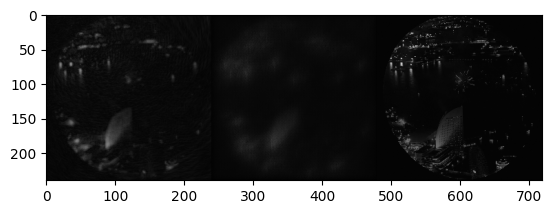

In [ ]:
#Inference
#Preproc series 1
if model_type=='VarNet':
    inputs=next(iter(dataset_withtransforms[-1]))
    output = model(inputs)
    zfill=tf.complex(inputs[0][0,...,0],inputs[0][0,...,1])
    gt=tf.complex(inputs[-1][0,...,0],inputs[-1][0,...,1])
    output=tf.complex(output[0,...,0],output[0,...,1])
elif model_type=='3DUNet':
    inputs,gt=next(iter(dataset_withtransforms[-1]))
    output = model(inputs)
    zfill=tf.complex(inputs[0,...,:10],inputs[0,...,10:])
    zfill=np.sqrt(np.sum(zfill*np.conj(zfill),axis=-1))
    gt=gt[0,...,0]
    output=output[0,...,0]
elif model_type=='FastDVDNet':
    inputs,gt=next(iter(dataset_withtransforms[-1]))
    output = model(inputs)
    zfill=inputs[0,...,-1]
    gt=gt[0,...,0]
    output=output[0,...,0]

#From Left to Right: Input, Ground Truth, Reconstructed.
if model_type=='FastDVDNet':
    savepath=os.path.join(exp_dir,'test_image_'+model_type)
    plot_image=np.abs(np.concatenate((zfill,output,gt),axis=1))
    plt.figure(figsize=(15,5))
    plt.imshow(plot_image,vmin=0,vmax=1,cmap='gray')
    plt.axis('off')
    plt.savefig(savepath)
else:
    savepath=os.path.join(exp_dir,'test_video_'+model_type)
    plot_image=np.abs(np.concatenate((zfill,output,gt),axis=2))
    display_func.plotVid(plot_image,axis=0,vmin=0,vmax=1,interval=41.66,savepath=savepath)